In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/news-recommendation/data/' # 天池平台路径
save_path = '/content/drive/MyDrive/news-recommendation/temp_results/'  # 天池平台路径

通过召回，我们缩减了问题规模。对于每个用户，选出了 N 篇文章作为候选集，并基于召回的候选集，构建了与用户历史相关的特征，用户本身属性特征、，文章本身属性特征，以及文章和用户之间的特征。

然后我们就可以使用机器学习模型，对构建好的特征进行学习，然后对测试集做预测，得到测试集中每个候选集用户点击概率，返回点击概率最大的 topk 文章。

LGB的排序模型

LGB的分类模型

深度学习的分类模型DIN

模型集成：
- 输出结果，加权融合
- staking（将模型输出的结果再用一个简单模型做预测）

In [ ]:
# 读取排序特征
base_path = Path('../tmp/projects/news_recommendation')
data_path = base_path / 'data_raw'
save_path = base_path / 'temp_results'
if not save_path.exists():
    save_path.mkdir(parents=True, exist_ok=True)

offline = False

# 重新读取数据的时候，发现click_article_id是一个浮点数，所以将其转换成int类型
trn_user_item_feats_df = pd.read_csv(save_path / 'trn_user_item_feats_df.csv')
trn_user_item_feats_df['click_article_id'] = trn_user_item_feats_df['click_article_id'].astype(int)

if offline:
    val_user_item_feats_df = pd.read_csv(save_path / 'val_user_item_feats_df.csv')
    val_user_item_feats_df['click_article_id'] = val_user_item_feats_df['click_article_id'].astype(int)
else:
    val_user_item_feats_df = None

tst_user_item_feats_df = pd.read_csv(save_path / 'tst_user_item_feats_df.csv')
tst_user_item_feats_df['click_article_id'] = tst_user_item_feats_df['click_article_id'].astype(int)

# 做特征的时候为了方便，给测试集也打上了一个无效的标签，这里直接删掉就行
del tst_user_item_feats_df['label']

## 返回排序后的结果

In [ ]:
def submit(recall_df, topk=5, model_name=None):
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

    # 判断是不是每个用户都有5篇文章及以上
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk

    del recall_df['pred_score']
    submit = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()

    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2',
                                                  3: 'article_3', 4: 'article_4', 5: 'article_5'})

    save_name = save_path / (model_name + '_' + datetime.today().strftime('%m-%d') + '.csv')
    submit.to_csv(save_name, index=False, header=True)

In [ ]:
# 排序结果归一化
def norm_sim(sim_df, weight=0.0):
    # print(sim_df.head())
    min_sim = sim_df.min()
    max_sim = sim_df.max()
    if max_sim == min_sim:
        sim_df = sim_df.apply(lambda sim: 1.0)
    else:
        sim_df = sim_df.apply(lambda sim: 1.0 * (sim - min_sim) / (max_sim - min_sim))

    sim_df = sim_df.apply(lambda sim: sim + weight)  # plus one
    return sim_df

# LGB 排序模型

In [ ]:
# 防止中间出错之后重新读取数据
trn_user_item_feats_df_rank_model = trn_user_item_feats_df.copy()

if offline:
    val_user_item_feats_df_rank_model = val_user_item_feats_df.copy()

tst_user_item_feats_df_rank_model = tst_user_item_feats_df.copy()

In [ ]:
# 定义特征列
lgb_cols = ['sim0', 'time_diff0', 'word_diff0','sim_max', 'sim_min', 'sim_sum',
            'sim_mean', 'score','click_size', 'time_diff_mean', 'active_level',
            'click_environment','click_deviceGroup', 'click_os', 'click_country',
            'click_region','click_referrer_type', 'user_time_hob1', 'user_time_hob2',
            'words_hbo', 'category_id', 'created_at_ts','words_count']

In [ ]:
# 定义特征列
lgb_cols = ['sim0', 'time_diff0', 'word_diff0','sim_max', 'sim_min', 'sim_sum',
            'sim_mean', 'score','click_size', 'time_diff_mean', 'active_level',
            'click_environment','click_deviceGroup', 'click_os', 'click_country',
            'click_region','click_referrer_type', 'user_time_hob1', 'user_time_hob2',
            'words_hbo', 'category_id', 'created_at_ts','words_count']

In [ ]:
# 排序模型定义
lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16)

In [ ]:
# 排序模型训练
if offline:
    lgb_ranker.fit(trn_user_item_feats_df_rank_model[lgb_cols], trn_user_item_feats_df_rank_model['label'], group=g_train,
                eval_set=[(val_user_item_feats_df_rank_model[lgb_cols], val_user_item_feats_df_rank_model['label'])],
                eval_group= [g_val], eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg', ])
else:
    lgb_ranker.fit(trn_user_item_feats_df[lgb_cols], trn_user_item_feats_df['label'], group=g_train)

In [ ]:
# 模型预测
tst_user_item_feats_df['pred_score'] = lgb_ranker.predict(tst_user_item_feats_df[lgb_cols], num_iteration=lgb_ranker.best_iteration_)

# 将这里的排序结果保存一份，用户后面的模型融合
tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']].to_csv(save_path / 'lgb_ranker_score.csv', index=False)

In [ ]:
# 预测结果重新排序, 及生成提交结果
rank_results = tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_ranker')

In [ ]:
# 五折交叉验证，这里的五折交叉是以用户为目标进行五折划分
#  这一部分与前面的单独训练和验证是分开的
def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['user_id'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = trn_user_item_feats_df_rank_model
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['user_id', 'click_article_id','label']]
sub_preds = np.zeros(tst_user_item_feats_df_rank_model.shape[0])

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['user_id'].isin(valid_user)]

    # 训练集与验证集的用户分组
    train_idx.sort_values(by=['user_id'], inplace=True)
    g_train = train_idx.groupby(['user_id'], as_index=False).count()["label"].values

    valid_idx.sort_values(by=['user_id'], inplace=True)
    g_val = valid_idx.groupby(['user_id'], as_index=False).count()["label"].values

    # 定义模型
    lgb_ranker = lgb.LGBMRanker(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16)
    # 训练模型
    lgb_ranker.fit(train_idx[lgb_cols], train_idx['label'], group=g_train,
                   eval_set=[(valid_idx[lgb_cols], valid_idx['label'])], eval_group= [g_val],
                   eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg', ])

    # 预测验证集结果
    valid_idx['pred_score'] = lgb_ranker.predict(valid_idx[lgb_cols], num_iteration=lgb_ranker.best_iteration_)

    # 对输出结果进行归一化
    valid_idx['pred_score'] = valid_idx[['pred_score']].transform(lambda x: norm_sim(x))

    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

    # 将验证集的预测结果放到一个列表中，后面进行拼接
    score_list.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])

    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds += lgb_ranker.predict(tst_user_item_feats_df_rank_model[lgb_cols], lgb_ranker.best_iteration_)

score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新特征
score_df[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_path / 'trn_lgb_ranker_feats.csv', index=False)

# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
tst_user_item_feats_df_rank_model['pred_score'] = sub_preds / k_fold
tst_user_item_feats_df_rank_model['pred_score'] = tst_user_item_feats_df_rank_model['pred_score'].transform(lambda x: norm_sim(x))
tst_user_item_feats_df_rank_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_rank_model['pred_rank'] = tst_user_item_feats_df_rank_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_path / 'tst_lgb_ranker_feats.csv', index=False)

In [ ]:
# 预测结果重新排序, 及生成提交结果
# 单模型生成提交结果
rank_results = tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_ranker')

# LGB 分类模型


In [ ]:
# 模型及参数的定义
lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=500, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16, verbose=10)

In [ ]:
# 模型训练
if offline:
    lgb_Classfication.fit(trn_user_item_feats_df_rank_model[lgb_cols], trn_user_item_feats_df_rank_model['label'],
                    eval_set=[(val_user_item_feats_df_rank_model[lgb_cols], val_user_item_feats_df_rank_model['label'])],
                    eval_metric=['auc', ])
else:
    lgb_Classfication.fit(trn_user_item_feats_df_rank_model[lgb_cols], trn_user_item_feats_df_rank_model['label'])

In [ ]:
# 模型预测
tst_user_item_feats_df['pred_score'] = lgb_Classfication.predict_proba(tst_user_item_feats_df[lgb_cols])[:,1]

# 将这里的排序结果保存一份，用户后面的模型融合
tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']].to_csv(save_path / 'lgb_cls_score.csv', index=False)

In [ ]:
# 预测结果重新排序, 及生成提交结果
rank_results = tst_user_item_feats_df[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_cls')

In [ ]:
# 五折交叉验证，这里的五折交叉是以用户为目标进行五折划分
#  这一部分与前面的单独训练和验证是分开的
def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['user_id'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = trn_user_item_feats_df_rank_model
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['user_id', 'click_article_id', 'label']]
sub_preds = np.zeros(tst_user_item_feats_df_rank_model.shape[0])

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['user_id'].isin(valid_user)]

    # 模型及参数的定义
    lgb_Classfication = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, reg_alpha=0.0, reg_lambda=1,
                            max_depth=-1, n_estimators=100, subsample=0.7, colsample_bytree=0.7, subsample_freq=1,
                            learning_rate=0.01, min_child_weight=50, random_state=2018, n_jobs= 16, verbose=10)
    # 训练模型
    lgb_Classfication.fit(train_idx[lgb_cols], train_idx['label'],eval_set=[(valid_idx[lgb_cols], valid_idx['label'])],
                          eval_metric=['auc', ])

    # 预测验证集结果
    valid_idx['pred_score'] = lgb_Classfication.predict_proba(valid_idx[lgb_cols],
                                                              num_iteration=lgb_Classfication.best_iteration_)[:,1]

    # 对输出结果进行归一化 分类模型输出的值本身就是一个概率值不需要进行归一化
    # valid_idx['pred_score'] = valid_idx[['pred_score']].transform(lambda x: norm_sim(x))

    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

    # 将验证集的预测结果放到一个列表中，后面进行拼接
    score_list.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])

    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds += lgb_Classfication.predict_proba(tst_user_item_feats_df_rank_model[lgb_cols],
                                                     num_iteration=lgb_Classfication.best_iteration_)[:,1]

score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新特征
score_df[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_path / 'trn_lgb_cls_feats.csv', index=False)

# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
tst_user_item_feats_df_rank_model['pred_score'] = sub_preds / k_fold
tst_user_item_feats_df_rank_model['pred_score'] = tst_user_item_feats_df_rank_model['pred_score'].transform(lambda x: norm_sim(x))
tst_user_item_feats_df_rank_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_rank_model['pred_rank'] = tst_user_item_feats_df_rank_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_path / 'tst_lgb_cls_feats.csv', index=False)

In [ ]:
# 预测结果重新排序, 及生成提交结果
rank_results = tst_user_item_feats_df_rank_model[['user_id', 'click_article_id', 'pred_score']]
rank_results['click_article_id'] = rank_results['click_article_id'].astype(int)
submit(rank_results, topk=5, model_name='lgb_cls')

# DIN 模型

## 用户的历史点击行为列表
为后续 DIN 模型服务

In [ ]:
if offline:
    all_data = pd.read_csv(data_path / 'train_click_log.csv')
else:
    trn_data = pd.read_csv(data_path / 'train_click_log.csv')
    tst_data = pd.read_csv(data_path / 'testA_click_log.csv')
    all_data = pd.concat([trn_data, tst_data]).reset_index(drop=True)

In [ ]:
hist_click =all_data[['user_id', 'click_article_id']].groupby('user_id').agg({list}).reset_index()
his_behavior_df = pd.DataFrame()
his_behavior_df['user_id'] = hist_click['user_id']
his_behavior_df['hist_click_article_id'] = hist_click['click_article_id']

In [ ]:
trn_user_item_feats_df_din_model = trn_user_item_feats_df.copy()

if offline:
    val_user_item_feats_df_din_model = val_user_item_feats_df.copy()
else:
    val_user_item_feats_df_din_model = None

tst_user_item_feats_df_din_model = tst_user_item_feats_df.copy()

In [ ]:
trn_user_item_feats_df_din_model = trn_user_item_feats_df_din_model.merge(his_behavior_df, on='user_id')

if offline:
    val_user_item_feats_df_din_model = val_user_item_feats_df_din_model.merge(his_behavior_df, on='user_id')
else:
    val_user_item_feats_df_din_model = None

tst_user_item_feats_df_din_model = tst_user_item_feats_df_din_model.merge(his_behavior_df, on='user_id')

### DIN 模型简介
Deep Interest Network，通过考虑【给定的候选广告】和【用户的历史行为】的相关性，来计算用户兴趣的表示向量。


具体来说就是通过引入局部激活单元，通过软搜索历史行为的相关部分来关注相关的用户兴趣，并采用加权和来获得有关候选广告的用户兴趣的表示。与候选广告相关性较高的行为会获得较高的激活权重，并支配着用户兴趣。该表示向量在不同广告上有所不同，大大提高了模型的表达能力。所以该模型对于此次新闻推荐的任务也比较适合， 我们在这里通过当前的候选文章与用户历史点击文章的相关性来计算用户对于文章的兴趣。

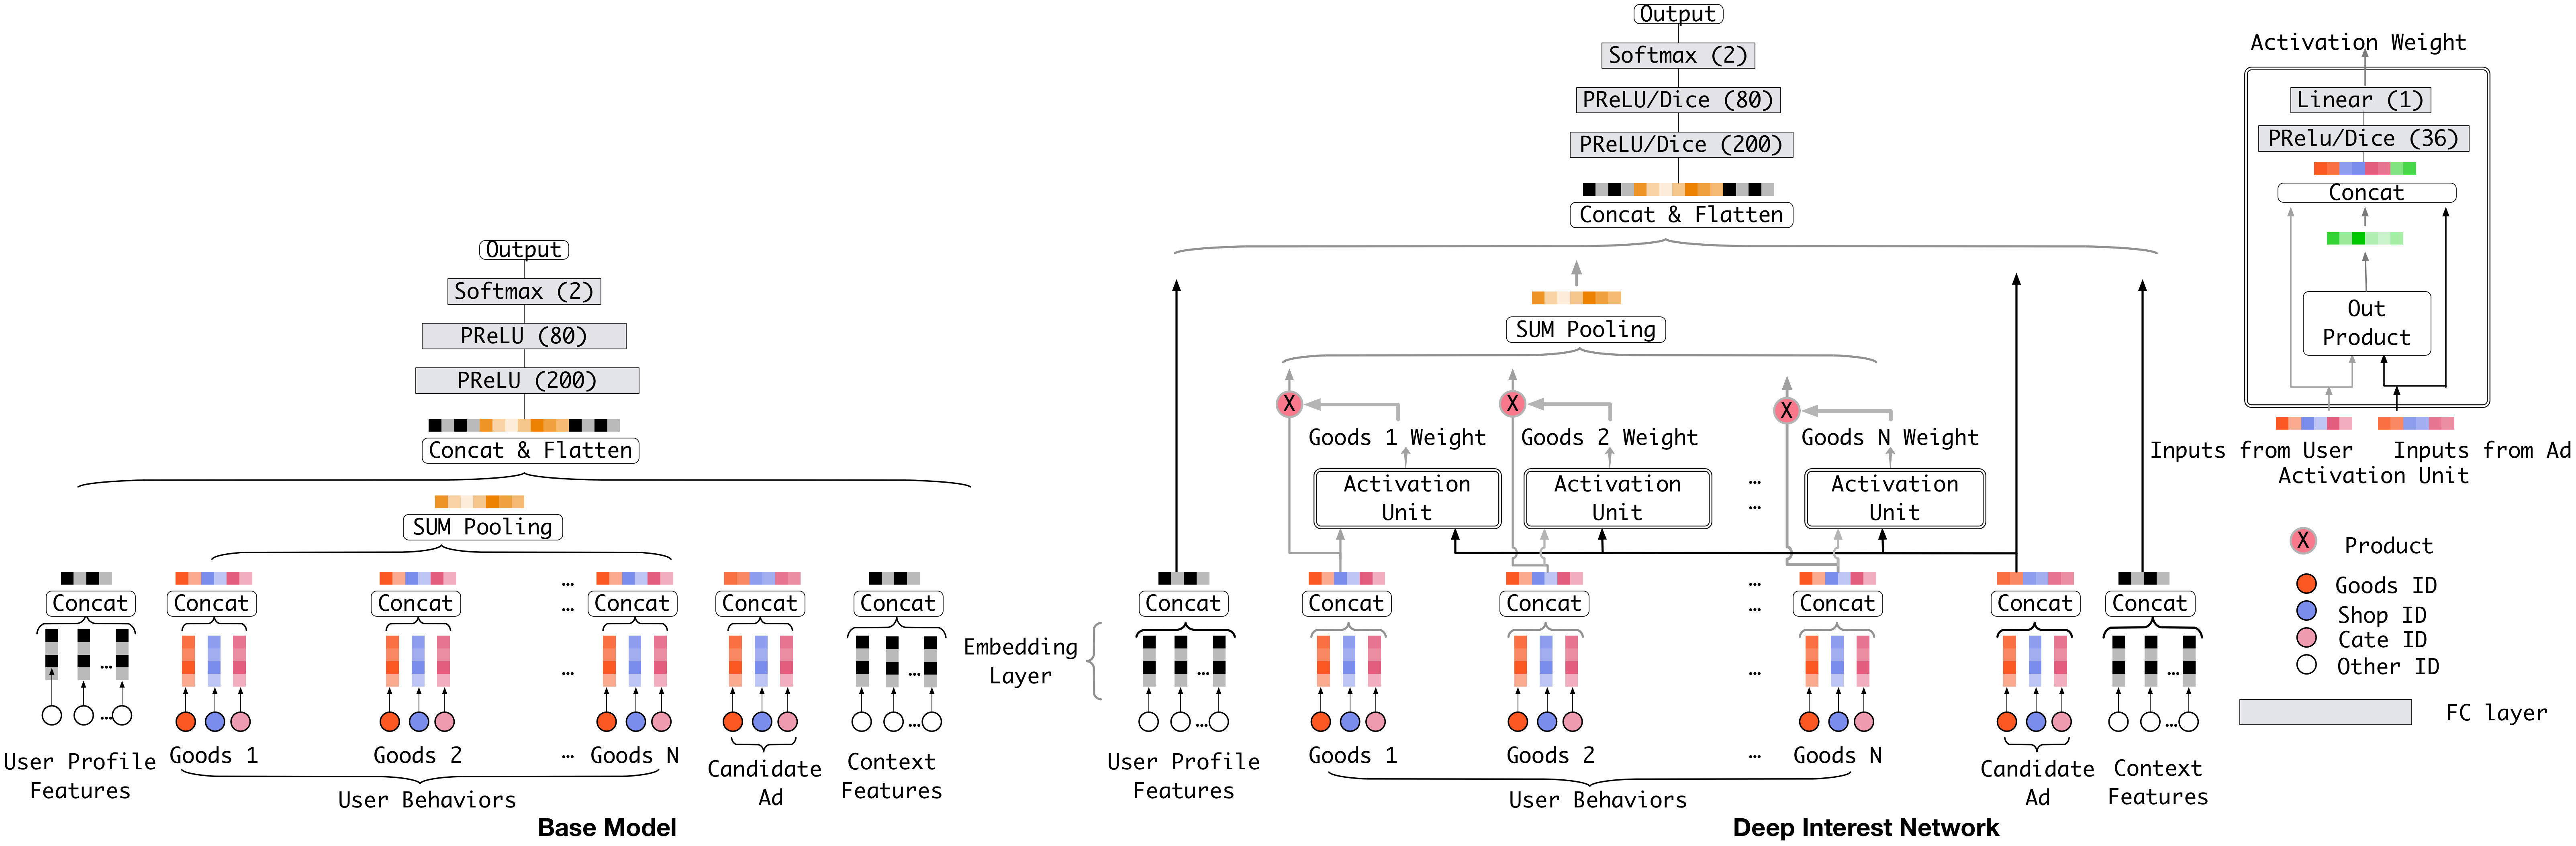

In [ ]:
def DIN(dnn_feature_columns, history_feature_list, dnn_use_bn=False,
       dnn_hidden_units=(200, 80), dnn_activation='relu', att_hidden_size=(80, 40), att_activation="dice",
      att_weight_normalization=False, l2_reg_dnn=0, l2_reg_embedding=1e-6, dnn_dropout=0, seed=1024,
       task='binary'):
    pass
    # * dnn_feature_columns: 特征列， 包含数据所有特征的列表
    # * history_feature_list: 用户历史行为列， 反应用户历史行为的特征的列表
    # * dnn_use_bn: 是否使用BatchNormalization
    # * dnn_hidden_units: 全连接层网络的层数和每一层神经元的个数， 一个列表或者元组
    # * dnn_activation_relu: 全连接网络的激活单元类型
    # * att_hidden_size: 注意力层的全连接网络的层数和每一层神经元的个数
    # * att_activation: 注意力层的激活单元类型
    # * att_weight_normalization: 是否归一化注意力得分
    # * l2_reg_dnn: 全连接网络的正则化系数
    # * l2_reg_embedding: embedding向量的正则化稀疏
    # * dnn_dropout: 全连接网络的神经元的失活概率
    # * task: 任务， 可以是分类， 也可是是回归

在具体使用的时候， 我们必须要传入特征列和历史行为列
1. 对于离散型特征， 在我们的数据集中就是那些类别型的特征， 比如user_id这种， 这种类别型特征， 我们首先要经过embedding处理得到每个特征的低维稠密型表示， 既然要经过embedding， 那么我们就需要为每一列的类别特征的取值建立一个字典，并指明embedding维度， 所以在使用deepctr的DIN模型准备数据的时候， 我们需要通过SparseFeat函数指明这些类别型特征, 这个函数的传入参数就是列名， 列的唯一取值(建立字典用)和embedding维度。

2. 对于用户历史行为特征列， 比如文章id， 文章的类别等这种， 同样的我们需要先经过embedding处理， 只不过和上面不一样的地方是，对于这种特征， 我们在得到每个特征的embedding表示之后， 还需要通过一个Attention_layer计算用户的历史行为和当前候选文章的相关性以此得到当前用户的embedding向量， 这个向量就可以基于当前的候选文章与用户过去点击过得历史文章的相似性的程度来反应用户的兴趣， 并且随着用户的不同的历史点击来变化，去动态的模拟用户兴趣的变化过程。这类特征对于每个用户都是一个历史行为序列， 对于每个用户， 历史行为序列长度会不一样， 可能有的用户点击的历史文章多，有的点击的历史文章少， 所以我们还需要把这个长度统一起来， 在为DIN模型准备数据的时候， 我们首先要通过SparseFeat函数指明这些类别型特征， 然后还需要通过VarLenSparseFeat函数再进行序列填充， 使得每个用户的历史序列一样长， 所以这个函数参数中会有个maxlen，来指明序列的最大长度是多少。

3. 对于连续型特征列， 我们只需要用DenseFeat函数来指明列名和维度即可。

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow as tf

In [ ]:
# 数据准备函数
def get_din_feats_columns(df, dense_fea, sparse_fea, behavior_fea, his_behavior_fea, emb_dim=32, max_len=100):
    """
    数据准备函数:
    df: 数据集
    dense_fea: 数值型特征列
    sparse_fea: 离散型特征列
    behavior_fea: 用户的候选行为特征列
    his_behavior_fea: 用户的历史行为特征列
    embedding_dim: embedding的维度， 这里为了简单， 统一把离散型特征列采用一样的隐向量维度
    max_len: 用户序列的最大长度
    """

    sparse_feature_columns = [SparseFeat(feat, vocabulary_size=df[feat].nunique() + 1, embedding_dim=emb_dim) for feat in sparse_fea]

    dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_fea]

    var_feature_columns = [VarLenSparseFeat(SparseFeat(feat, vocabulary_size=df['click_article_id'].nunique() + 1,
                                    embedding_dim=emb_dim, embedding_name='click_article_id'), maxlen=max_len) for feat in hist_behavior_fea]

    dnn_feature_columns = sparse_feature_columns + dense_feature_columns + var_feature_columns

    # 建立x, x是一个字典的形式
    x = {}
    for name in get_feature_names(dnn_feature_columns):
        if name in his_behavior_fea:
            # 这是历史行为序列
            his_list = [l for l in df[name]]
            x[name] = pad_sequences(his_list, maxlen=max_len, padding='post')      # 二维数组
        else:
            x[name] = df[name].values

    return x, dnn_feature_columns

In [ ]:
def get_din_input_data(df, dense_fea, sparse_fea, behavior_fea, his_behavior_fea, emb_dim=32, max_len=100):
    dnn_feature_columns = sparse_fea + dense_fea + his_behavior_fea
    x = {}
    # Sparse features (map if sparse_maps available)
    for name in sparse_fea:
        if 'sparse_maps' in globals() and name in sparse_maps:
            x[name] = df[name].astype('int64').map(sparse_maps[name]).fillna(0).astype('int32').values
        else:
            x[name] = df[name].astype('int32').values
    # Dense features
    for name in dense_fea:
        x[name] = df[name].astype('float32').values
    # History sequence (map with click_article_id map if available)
    for name in his_behavior_fea:
        seq_list = df[name].tolist()
        if 'sparse_maps' in globals() and 'click_article_id' in sparse_maps:
            cmap = sparse_maps['click_article_id']
            mapped_seq = []
            for seq in seq_list:
                if isinstance(seq, (list, np.ndarray)):
                    mapped_seq.append([int(cmap.get(int(v), 0)) if int(v) != 0 else 0 for v in seq])
                else:
                    mapped_seq.append([0])
            x[name] = pad_sequences(mapped_seq, maxlen=max_len, padding='post')
        else:
            x[name] = pad_sequences(seq_list, maxlen=max_len, padding='post')
    return x, dnn_feature_columns

In [ ]:
# 把特征分开
sparse_fea = ['user_id', 'click_article_id', 'category_id', 'click_environment', 'click_deviceGroup',
              'click_os', 'click_country', 'click_region', 'click_referrer_type', 'is_cat_hab']

behavior_fea = ['click_article_id']

hist_behavior_fea = ['hist_click_article_id']

dense_fea = ['sim0', 'time_diff0', 'word_diff0', 'sim_max', 'sim_min', 'sim_sum', 'sim_mean', 'score',
             'rank','click_size','time_diff_mean','active_level','user_time_hob1','user_time_hob2',
             'words_hbo','words_count']

In [ ]:
# dense特征进行归一化, 神经网络训练都需要将数值进行归一化处理
mm = MinMaxScaler()

# 下面是做一些特殊处理，当在其他的地方出现无效值的时候，不处理无法进行归一化，刚开始可以先把他注释掉，在运行了下面的代码
# 之后如果发现报错，应该先去想办法处理如何不出现inf之类的值
# trn_user_item_feats_df_din_model.replace([np.inf, -np.inf], 0, inplace=True)
# tst_user_item_feats_df_din_model.replace([np.inf, -np.inf], 0, inplace=True)

for feat in dense_fea:
    trn_user_item_feats_df_din_model[feat] = mm.fit_transform(trn_user_item_feats_df_din_model[[feat]])

    if val_user_item_feats_df_din_model is not None:
        val_user_item_feats_df_din_model[feat] = mm.fit_transform(val_user_item_feats_df_din_model[[feat]])

    tst_user_item_feats_df_din_model[feat] = mm.fit_transform(tst_user_item_feats_df_din_model[[feat]])

In [ ]:
# funrec DIN 排序
import sys

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

# FunRec 导入
from funrec.features.feature_column import FeatureColumn
from funrec.training.trainer import train_model as funrec_train_model

# 1) 配置 (mirrors funrec/config/config_din.yaml)
funrec_config = {
    'training': {
        'build_function': 'funrec.models.din.build_din_model',
        'model_params': {
            'dnn_units': [128, 64, 1],
            'linear_logits': True,
        },
        'optimizer': 'adam',
        'loss': 'binary_crossentropy',
        'metrics': ['binary_accuracy'],
        'batch_size': 128,
        'epochs': 2,
        'validation_split': 0.2,
        'verbose': 1,
    }
}

# 2) 构建特征列
emb_dim = 8
max_len = 50

def _nunique(series_list):
    return int(pd.concat(series_list, ignore_index=True).nunique())

# 使用已有的splits
df_trn = trn_user_item_feats_df_din_model
df_val = val_user_item_feats_df_din_model if val_user_item_feats_df_din_model is not None else None
df_tst = tst_user_item_feats_df_din_model

all_frames = [df_trn, df_tst] + ([df_val] if df_val is not None else [])

# 为所有稀疏特征构建连续id映射
sparse_maps = {}
for feat in sparse_fea:
    vals = pd.concat([f[feat].astype('int64') for f in all_frames], ignore_index=True)
    if feat == 'click_article_id':
        hist_vals = []
        for f in all_frames:
            for seq in f['hist_click_article_id']:
                if isinstance(seq, (list, np.ndarray)):
                    hist_vals.extend([int(x) for x in seq])
        if len(hist_vals) > 0:
            vals = pd.concat([vals, pd.Series(hist_vals, dtype='int64')], ignore_index=True)
    codes, uniques = pd.factorize(vals, sort=False)
    mapping = {int(val): int(idx) for idx, val in enumerate(uniques)}
    if feat == 'click_article_id':
        # 保留0用于序列填充
        mapping = {k: v + 1 for k, v in mapping.items()}
    sparse_maps[feat] = mapping

def _vocab_size(mapping: dict) -> int:
    return (max(mapping.values()) + 1) if mapping else 1

feature_columns = []

# 稀疏特征 (dnn)
for feat in sparse_fea:
    vocab = _vocab_size(sparse_maps[feat])
    feature_columns.append(
        FeatureColumn(
            name=feat,
            emb_name=feat,
            emb_dim=emb_dim,
            vocab_size=vocab,
            group=['dnn'],
            type='sparse',
        )
    )

# 稠密特征
for feat in dense_fea:
    feature_columns.append(
        FeatureColumn(
            name=feat,
            emb_name=None,
            type='dense',
            dimension=1,
            group=['dnn'],
            dtype='float32',
        )
    )

# 变长稀疏特征: hist_click_article_id使用click_article_id embedding
click_vocab = _vocab_size(sparse_maps['click_article_id'])
feature_columns.append(
    FeatureColumn(
        name='hist_click_article_id',
        emb_name='click_article_id',
        emb_dim=emb_dim,
        vocab_size=click_vocab,
        group=['dnn'],
        type='varlen_sparse',
        max_len=max_len,
        combiner='mean,din',
        att_key_name='click_article_id',
    )
)

# 3) 构建模型输入
def build_model_input(df: pd.DataFrame) -> dict:
    model_input = {}
    # 稀疏特征
    for feat in sparse_fea:
        mapped = df[feat].astype('int64').map(sparse_maps[feat]).fillna(0).astype('int32').values
        model_input[feat] = mapped
    # 稠密特征
    for feat in dense_fea:
        model_input[feat] = df[feat].astype('float32').values
    # 变长稀疏特征 (右填充)
    raw_seq_list = df['hist_click_article_id'].tolist()
    mapped_seq = []
    cmap = sparse_maps['click_article_id']
    for seq in raw_seq_list:
        if isinstance(seq, (list, np.ndarray)):
            mapped_seq.append([int(cmap.get(int(x), 0)) if int(x) != 0 else 0 for x in seq])
        else:
            mapped_seq.append([0])
    model_input['hist_click_article_id'] = pad_sequences(mapped_seq, maxlen=max_len, padding='post').astype('int32')
    return model_input

x_trn_funrec = build_model_input(df_trn)
y_trn_funrec = df_trn['label'].values.astype('float32')

if offline and df_val is not None:
    x_val_funrec = build_model_input(df_val)
    y_val_funrec = df_val['label'].values.astype('float32')

x_tst_funrec = build_model_input(df_tst)

processed_data = {
    'train': {
        'features': x_trn_funrec,
        'labels': y_trn_funrec,
    },
    'test': {
        'features': x_tst_funrec,
        'labels': {},
    },
}

# 4) 训练FunRec DIN
main_model, _, _ = funrec_train_model(funrec_config['training'], feature_columns, processed_data)

# 5) 预测和保存结果
tst_user_item_feats_df_din_model['pred_score'] = main_model.predict(x_tst_funrec, batch_size=256, verbose=1)
tst_user_item_feats_df_din_model[['user_id', 'click_article_id', 'pred_score']].to_csv(save_path / 'din_rank_score.csv', index=False)

rank_results = tst_user_item_feats_df_din_model[['user_id', 'click_article_id', 'pred_score']]

In [ ]:
# 预测结果重新排序, 及生成提交结果
submit(rank_results, topk=5, model_name='din')

In [ ]:
# 五折交叉验证，这里的五折交叉是以用户为目标进行五折划分
#  这一部分与前面的单独训练和验证是分开的
def get_kfold_users(trn_df, n=5):
    user_ids = trn_df['user_id'].unique()
    user_set = [user_ids[i::n] for i in range(n)]
    return user_set

k_fold = 5
trn_df = trn_user_item_feats_df_din_model
user_set = get_kfold_users(trn_df, n=k_fold)

score_list = []
score_df = trn_df[['user_id', 'click_article_id', 'label']]
sub_preds = np.zeros(tst_user_item_feats_df_rank_model.shape[0])

dense_fea = [x for x in dense_fea if x != 'label']
# x_tst, dnn_feature_columns = get_din_feats_columns(tst_user_item_feats_df_din_model, dense_fea,
#                                                    sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)

x_tst, _ = get_din_input_data(tst_user_item_feats_df_din_model, dense_fea, sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)

# 五折交叉验证，并将中间结果保存用于staking
for n_fold, valid_user in enumerate(user_set):
    train_idx = trn_df[~trn_df['user_id'].isin(valid_user)] # add slide user
    valid_idx = trn_df[trn_df['user_id'].isin(valid_user)]

    # 准备训练数据
    # x_trn, dnn_feature_columns = get_din_feats_columns(train_idx, dense_fea,
    #                                                    sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)
    x_trn, _ = get_din_input_data(train_idx, dense_fea, sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)
    y_trn = train_idx['label'].values

    # 准备验证数据
    # x_val, dnn_feature_columns = get_din_feats_columns(valid_idx, dense_fea,
    #                                                sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)
    x_val, _ = get_din_input_data(valid_idx, dense_fea, sparse_fea, behavior_fea, hist_behavior_fea, max_len=50)
    y_val = valid_idx['label'].values

    history = main_model.fit(x_trn, y_trn, verbose=1, epochs=2, validation_data=(x_val, y_val) , batch_size=256)

    # 预测验证集结果
    valid_idx['pred_score'] = main_model.predict(x_val, verbose=1, batch_size=256).flatten()

    valid_idx.sort_values(by=['user_id', 'pred_score'])
    valid_idx['pred_rank'] = valid_idx.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

    # 将验证集的预测结果放到一个列表中，后面进行拼接
    score_list.append(valid_idx[['user_id', 'click_article_id', 'pred_score', 'pred_rank']])

    # 如果是线上测试，需要计算每次交叉验证的结果相加，最后求平均
    if not offline:
        sub_preds += main_model.predict(x_tst, verbose=1, batch_size=256).flatten()

score_df_ = pd.concat(score_list, axis=0)
score_df = score_df.merge(score_df_, how='left', on=['user_id', 'click_article_id'])
# 保存训练集交叉验证产生的新特征
score_df[['user_id', 'click_article_id', 'pred_score', 'pred_rank', 'label']].to_csv(save_path / 'trn_din_cls_feats.csv', index=False)

# 测试集的预测结果，多次交叉验证求平均,将预测的score和对应的rank特征保存，可以用于后面的staking，这里还可以构造其他更多的特征
tst_user_item_feats_df_din_model['pred_score'] = sub_preds / k_fold
tst_user_item_feats_df_din_model['pred_score'] = tst_user_item_feats_df_din_model['pred_score'].transform(lambda x: norm_sim(x))
tst_user_item_feats_df_din_model.sort_values(by=['user_id', 'pred_score'])
tst_user_item_feats_df_din_model['pred_rank'] = tst_user_item_feats_df_din_model.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')

# 保存测试集交叉验证的新特征
tst_user_item_feats_df_din_model[['user_id', 'click_article_id', 'pred_score', 'pred_rank']].to_csv(save_path / 'tst_din_cls_feats.csv', index=False)

# 模型融合

## 加权融合


In [ ]:
# 读取多个模型的排序结果文件
lgb_ranker = pd.read_csv(save_path / 'lgb_ranker_score.csv')
lgb_cls = pd.read_csv(save_path / 'lgb_cls_score.csv')
din_ranker = pd.read_csv(save_path / 'din_rank_score.csv')

# 这里也可以换成交叉验证输出的测试结果进行加权融合

In [ ]:
rank_model = {'lgb_ranker': lgb_ranker,
              'lgb_cls': lgb_cls,
              'din_ranker': din_ranker}

In [ ]:
get_ensumble_predict_topk(rank_model)

## Staking

In [ ]:
# 读取多个模型的交叉验证生成的结果文件
# 训练集
trn_lgb_ranker_feats = pd.read_csv(save_path / 'trn_lgb_ranker_feats.csv')
trn_lgb_cls_feats = pd.read_csv(save_path / 'trn_lgb_cls_feats.csv')
trn_din_cls_feats = pd.read_csv(save_path / 'trn_din_cls_feats.csv')

# 测试集
tst_lgb_ranker_feats = pd.read_csv(save_path / 'tst_lgb_ranker_feats.csv')
tst_lgb_cls_feats = pd.read_csv(save_path / 'tst_lgb_cls_feats.csv')
tst_din_cls_feats = pd.read_csv(save_path / 'tst_din_cls_feats.csv')

In [ ]:
# 将多个模型输出的特征进行拼接

finall_trn_ranker_feats = trn_lgb_ranker_feats[['user_id', 'click_article_id', 'label']]
finall_tst_ranker_feats = tst_lgb_ranker_feats[['user_id', 'click_article_id']]

for idx, trn_model in enumerate([trn_lgb_ranker_feats, trn_lgb_cls_feats, trn_din_cls_feats]):
    for feat in [ 'pred_score', 'pred_rank']:
        col_name = feat + '_' + str(idx)
        finall_trn_ranker_feats[col_name] = trn_model[feat]

for idx, tst_model in enumerate([tst_lgb_ranker_feats, tst_lgb_cls_feats, tst_din_cls_feats]):
    for feat in [ 'pred_score', 'pred_rank']:
        col_name = feat + '_' + str(idx)
        finall_tst_ranker_feats[col_name] = tst_model[feat]

In [ ]:
# 定义一个逻辑回归模型再次拟合交叉验证产生的特征对测试集进行预测
# 这里需要注意的是，在做交叉验证的时候可以构造多一些与输出预测值相关的特征，来丰富这里简单模型的特征
from sklearn.linear_model import LogisticRegression

feat_cols = ['pred_score_0', 'pred_rank_0', 'pred_score_1', 'pred_rank_1', 'pred_score_2', 'pred_rank_2']

trn_x = finall_trn_ranker_feats[feat_cols]
trn_y = finall_trn_ranker_feats['label']

tst_x = finall_tst_ranker_feats[feat_cols]

# 采样50000行数据 因为全量数据太大了
sample_indices = trn_x.sample(n=50000, random_state=42).index
trn_x_sample = trn_x.loc[sample_indices]
trn_y_sample = trn_y.loc[sample_indices]

print(f"Original training data shape: {trn_x.shape}")
print(f"Sampled training data shape: {trn_x_sample.shape}")

# 定义模型
lr = LogisticRegression()

# 模型训练
lr.fit(trn_x_sample, trn_y_sample)

# 模型预测
test_score = []
test_batch_size = 10000
for i in tqdm(range(0, len(tst_x), test_batch_size), total=len(tst_x)//test_batch_size, desc="Predicting test score"):
    test_score.append(lr.predict_proba(tst_x.iloc[i:i+test_batch_size])[:, 1])

finall_tst_ranker_feats['pred_score'] = np.concatenate(test_score)